<a href="https://colab.research.google.com/github/kaiqueg-costa/kaggle-intro-to-machine-learning/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will analyze Google Play reviews for the FGTS app, which is a Brazilian government application that allows employees to check their account balance for government savings program for workers.

## Importing libs

In [2]:
!pip install google_play_scraper
!pip install unidecode
!pip install openpyxl
!pip install -q xlrd
!pip install -U scikit-learn
!pip install wordcloud
!pip install seaborn
!pip install nltk


from google_play_scraper import Sort, reviews
from datetime import datetime as dt
import unidecode
import warnings
import pandas as pd
import unidecode
import sklearn
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
from nltk import tokenize
from nltk import ngrams
import pickle
import re

warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

## Creating dataframe 

In [4]:
fgts_reviews, _ = reviews(
    'br.gov.caixa.fgts.trabalhador',
    lang='pt', 
    count=50000,
    country='br', 
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [5]:
df = pd.DataFrame(fgts_reviews)

In [6]:
df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,59404f5c-bb0c-44fd-ae64-137bb2b4d213,sabrina _silva,https://play-lh.googleusercontent.com/a-/ACB-R...,"Fui ajudar o meu pai e deu tudo errado,tive qu...",1,0,None,2023-05-11 12:18:01,"Olá. Por favor, verifique se a versão do seu a...",2023-05-11 12:20:14,None
1,ab0ab6ce-4db6-4358-81f8-b1eb200d5f1c,Luiz Carlos Maciel,https://play-lh.googleusercontent.com/a/AGNmyx...,Ótimo,5,0,3.39.2,2023-05-11 12:17:53,Olá! Obrigada por compartilhar sua experiência...,2023-05-11 12:20:24,3.39.2
2,6dc16b32-8879-4243-9e73-c8277d201cf2,Janderson Gonçalves da Costa,https://play-lh.googleusercontent.com/a/AGNmyx...,Muito bom,5,0,None,2023-05-11 12:17:11,Olá! Obrigada por compartilhar sua experiência...,2023-05-11 12:20:35,None
3,023a3126-5944-4b91-8ea6-1b78fe7d12fc,Allessandra Ellias,https://play-lh.googleusercontent.com/a-/ACB-R...,Estou tentando desde ontem autoriza um banco e...,1,0,3.35.3,2023-05-11 12:16:24,"Olá. Por favor, verifique se a versão do seu a...",2023-05-11 12:20:45,3.35.3
4,c0a18eb8-192c-4d15-bdbd-a43902d08dce,Diego A. Silva,https://play-lh.googleusercontent.com/a-/ACB-R...,Aplicativo não mostra as contas do FGTS e está...,1,0,3.39.2,2023-05-11 12:15:05,"Olá. Por favor, verifique se a versão do seu a...",2023-05-11 12:16:15,3.39.2


# Training the Sentiment Model

### Exploring df

In [7]:
df.shape

(50000, 11)

In [8]:
# selecting some columns

df = df[['reviewId', 'content', 'score', 'at']]

df.head(2)

,reviewId,content,score,at
0,59404f5c-bb0c-44fd-ae64-137bb2b4d213,"Fui ajudar o meu pai e deu tudo errado,tive qu...",1,2023-05-11 12:18:01
1,ab0ab6ce-4db6-4358-81f8-b1eb200d5f1c,Ótimo,5,2023-05-11 12:17:53


In [9]:
# creating month column

df['month'] = df['at'].dt.strftime('%Y%m').astype(int)

In [10]:
# count of monthly reviews

count = df['month'].value_counts().sort_index()
prop = df['month'].value_counts(normalize = True).sort_index()

result = pd.concat([count, prop], axis = 1)
result.columns = ['count', 'proportion']

result

,count,proportion
202302,17658,0.35316
202303,14095,0.28190
202304,10405,0.20810
202305,7842,0.15684


As the table above, when we limit the dataset to the last 100K rows the dataframe will have data between part of september and current day in may.

For our project, we'll be working with a subset of this data.

**Let's use april to train the model and may to test.**

In [11]:
# selecting a subset

df_train = df.loc[df['month'] == 202304].copy()

In [12]:
# exporting the .xslx file to train the model

# df.to_excel('/content/drive/MyDrive/Estudos/Projetos/Python/fgts_train.xlsx')

In [13]:
# importing the .xslx file trained

df_train = pd.read_excel('/content/drive/MyDrive/Estudos/Projetos/Python/fgts_train.xlsx', engine = 'openpyxl')

In [14]:
df_train

,Unnamed: 0,reviewId,content,score,at,month,sentiment
0,5895,7d2b5c31-464f-477f-88b8-34b7b51f4fd3,Muito bom recomendo,5,2023-04-30 23:56:57,202304,1
1,5896,6e0a7ee7-f67c-441c-81e5-d404eab9eab6,Gostei obrigado!!!!,5,2023-04-30 23:48:34,202304,1
2,5897,714f8b1d-a577-4444-afb5-31aed41755aa,Muito bom pra quem quer o saldo do FGTS para s...,5,2023-04-30 23:45:06,202304,1
3,5898,6f69db4b-3c85-45f0-8930-8f467240c124,Bom,5,2023-04-30 23:43:17,202304,1
4,5899,caa4bf59-f36e-4308-b37d-021a0b4b26e7,Eficas,5,2023-04-30 23:26:49,202304,1
...,...,...,...,...,...,...,...
10409,16304,6f05db46-bc6c-430c-8695-d8b20e795dd8,Boa,4,2023-04-01 00:24:29,202304,1
10410,16305,8e41ca53-48e9-4f02-9c2a-d5737b79eb15,O mundo se atualiza e a caixa não. Mudei de ce...,1,2023-04-01 00:19:13,202304,-1
10411,16306,79daf6a0-5370-4a34-8701-0bce7c3ad69f,Excelente.,5,2023-04-01 00:18:24,202304,1
10412,16307,a2d9a9e0-b695-4580-b38a-9ad6bb97931d,Bom,5,2023-04-01 00:07:11,202304,1


## Analyzing and treating df train

In [15]:
df_train['sentiment'].value_counts()

 1    8080
-1    2334
Name: sentiment, dtype: int64

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10414 entries, 0 to 10413
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  10414 non-null  int64         
 1   reviewId    10414 non-null  object        
 2   content     10414 non-null  object        
 3   score       10414 non-null  int64         
 4   at          10414 non-null  datetime64[ns]
 5   month       10414 non-null  int64         
 6   sentiment   10414 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 569.6+ KB


## Word Cloud

In [17]:
def word_cloud(df: pd.DataFrame, text_column: str, sentiment: int, title: str):
  """
  Create a wordcloud with data from a dataframe column 

  Args:
    df (pd.DataFrame): A Pandas DataFrame containing the text column
    text_column (str): Column with text
    sentiment (int): Sentiment to filter
    title (str): Chart title
  """
  # dataframe rows join

  text = df[text_column].loc[df['sentiment'] == sentiment]
  text_all = ' '.join([i for i in text.astype(str)])

  # wordcloud parameters

  wordcloud = WordCloud(width = 800,
                      height = 500,
                      max_font_size = 110,
                      collocations = False).generate(text_all)
  # image config
   
  plt.figure(figsize = (10,7))
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.title(title)
  plt.show()  

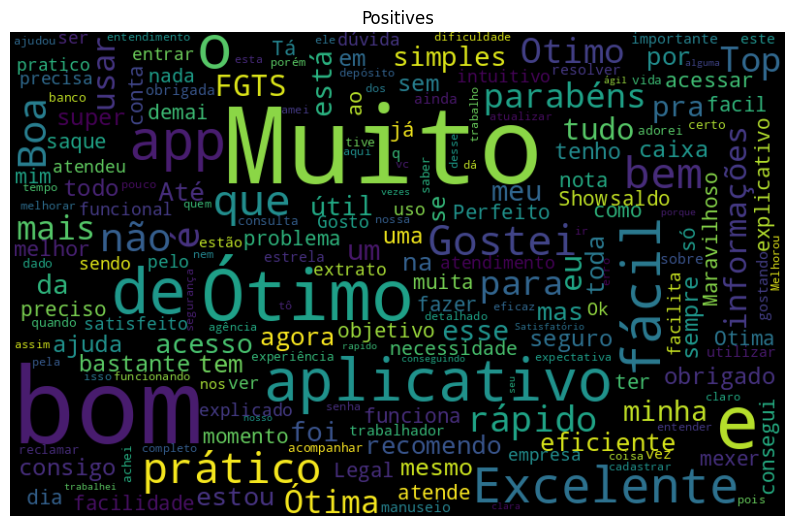

In [18]:
word_cloud(df_train, 'content', 1, 'Positives')

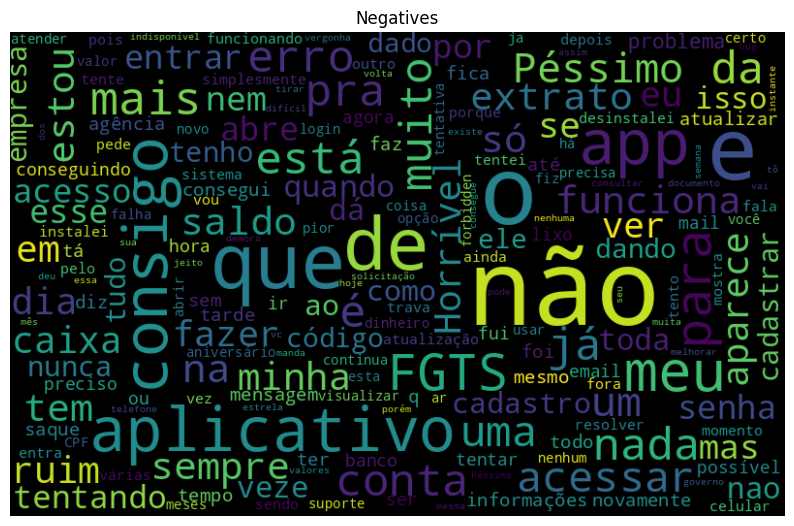

In [19]:
word_cloud(df_train, 'content', -1, 'Negatives')

## Text cleaning

#### Stopwords and punctuation

In [20]:
# list of stopwords

stopwords = nltk.corpus.stopwords.words('portuguese')

In [21]:
# list of punctuations

punctuation_list = list()

for i in punctuation:
  punctuation_list.append(i)

In [22]:
# lists union

stopwords_punctuation = stopwords + punctuation_list

print(stopwords_punctuation)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

#### Normalized reviews

In [23]:
def normalized_review(df: pd.DataFrame, text_column: str, new_column: str):
  """
   This function normalizes the words in a text column by converting the text to lowercase, removing accents and non-alphanumeric characters,
   tokenizing the words, removing stop words and punctuation, and stemming the remaining words.

  Args:
    df (pd.DataFrame): A Pandas DataFrame containing the text column to normalize.
    text_column (str): The name of the column containing the text to normalize.
    new_column (str): The name of the new column to create, containing the normalized text.
  """

  stemmer = nltk.RSLPStemmer() # word stemming function

  normalized_review = list() 

  for i in df[text_column].astype(str):

    normalized_words = list()
    token = tokenize.WordPunctTokenizer() # tokenization function

    text = i.lower() # converts text to lowercase
    text = unidecode.unidecode(text) # remove accents
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # removes non-alphanumeric characters

    token = token.tokenize(text) # tokenize the words

    for word in token:
      if word not in stopwords_punctuation:
        normalized_words.append(stemmer.stem(word)) # stemmezation of words

    normalized_review.append(' '.join(normalized_words))

  df[new_column] = normalized_review

In [24]:
normalized_review(df_train, 'content', 'normalized_content')

In [25]:
df_train.sample(10)

,Unnamed: 0,reviewId,content,score,at,month,sentiment,normalized_content
8851,14746,8b092fe9-b545-4c27-b957-d264fa0407ae,Ótimo,5,2023-04-06 11:56:55,202304,1,otim
5553,11448,c5d98cfb-017b-4860-b64e-a2fe1b1eaa7d,Não funciona as mais de 10 dias fui na agência...,1,2023-04-14 19:37:18,202304,-1,nao func 10 dia agenc hj pra tent resolv fiz n...
8965,14860,a4143a3c-1f04-4a3d-a7fd-415546f5739a,Estou a dias tentando atualizar meus dados cad...,1,2023-04-05 22:01:47,202304,-1,dia tent atual dad cadastr aparelh ja tent out...
5891,11786,9bfb33b5-425b-40f2-96f6-a9bc4e9aa5c1,"O app não salva as informações de entrada, tod...",1,2023-04-14 01:50:04,202304,-1,app nao salv informaco entr tod hor vou entr a...
6020,11915,4310ce06-8189-4d4b-adc4-10b31329c7ba,Muito bom,5,2023-04-13 21:07:15,202304,1,bom
5586,11481,d4f9d1bd-d6a4-4747-a989-49e5f64de2b9,Muito difícil. Quase não consigo terminar o me...,4,2023-04-14 18:39:58,202304,1,dificil quas nao consig termin cadastr
8427,14322,4440e1f1-6148-4431-a11e-3e0e8d6cc2f2,Trocaram minha senha que uso há 20 anos e agor...,4,2023-04-07 20:39:35,202304,1,troc senh uso ha 20 ano agor nao consig acess ...
3112,9007,f05b392a-85e5-4418-804f-7227342ad410,"Parabéns pela iniciativa, de facilitar ainda m...",5,2023-04-20 17:15:03,202304,1,parab inici facil aind dificuldad exist vid si...
1400,7295,a2f8e4e0-d89f-4ec2-b794-03db0f0435f3,Sinceramente tô decepcionada com isso estou te...,1,2023-04-26 14:35:47,202304,-1,sinc to decepcion tent entr app fgt direit nao...
5326,11221,24cd1500-0914-4c82-8a35-df0e76556871,Muito bom o aplicativo bem viável e seguro por...,5,2023-04-15 15:16:22,202304,1,bom aplic bem viavel segur por dev corrig algu...


#### New Word Cloud with normalized text

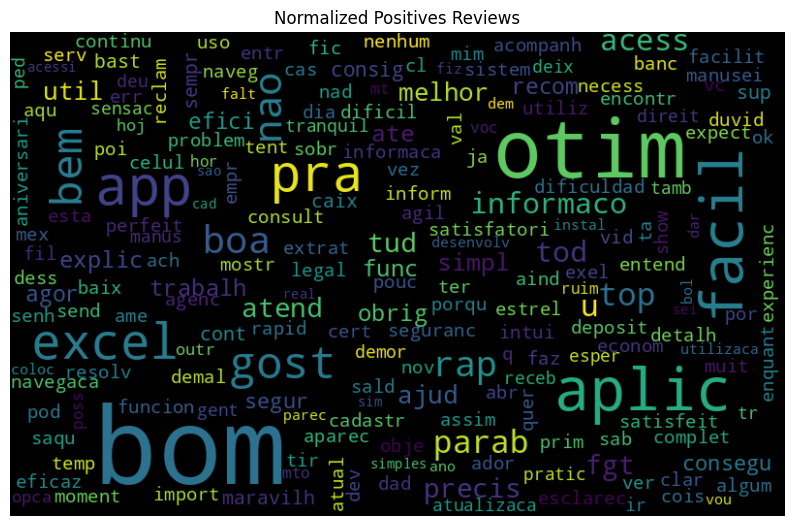

In [26]:
word_cloud(df_train, 'normalized_content', 1, 'Normalized Positives Reviews')

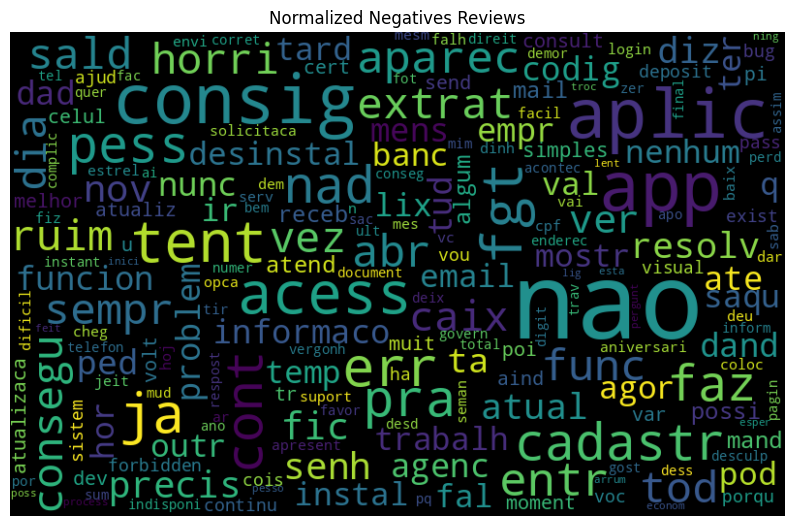

In [27]:
word_cloud(df_train, 'normalized_content', -1, 'Normalized Negatives Reviews')

The wordcloud seems more accurate after words normalization. 

We are now able to better visualize adverbs and distinct words that appears in reviews.

## Logistic Regression Model

In [28]:
def sentiment_model(df: pd.DataFrame, text_column: str, trained_sentiment_column: int):
    """
    This function train a Logistic Regression model to learn how to classify the text sentiment
    through the trained data and the score column.
    
    Args:
        df (pd.DataFrame): A Pandas DataFrame containing the text column to normalize.
        text_column (str): The name of the column containing the text to normalize.
        trained_sentiment_column (int): The name of the column containing the trained sentiment labels (-1 or 1)

    This function vectorizes the text data using the bag of words technique, where each unique word is 
    considered a feature, and the frequency of each word is counted to represent the text as a vector. 
    The vectorized data is then split into training and test sets, and a logistic regression model is 
    trained on the training set to classify the sentiment of the text data. The trained model is saved in 
    a pickle file for later use. The function returns the accuracy score of the trained model on the test data.
    """

    vector = CountVectorizer(max_features = 50, ngram_range = (1,2)) # setting parameters to vectorize the words
    bag_of_words = vector.fit_transform(df[text_column]) # bag of words to count the frequency of each word to represent the review as a vector
    
    df_bag_of_words = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns = vector.get_feature_names_out()) # transform sparse matrix in pandas dataframe
    df_bag_of_words = pd.concat([df['score'], df_bag_of_words], axis = 1) # adding score column to dataframe
    df_bag_of_words = pd.DataFrame.to_numpy(df_bag_of_words) # transform dataframe to numpy array
    
    # separate the dataframe in test and train subsets

    X_train, X_test, y_train, y_test = train_test_split(df_bag_of_words,
                                                                    df[trained_sentiment_column])
    # apply the logistc regression

    regression = LogisticRegression(solver = 'lbfgs', max_iter = 500)
    regression.fit(X_train, y_train)
    
    # saving the model in pickle file

    with open('/content/drive/MyDrive/Estudos/Projetos/Python/fgts_sentiment.pickle', 'wb') as handle:
        pickle.dump(regression, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return regression.score(X_test, y_test)

In [29]:
sentiment_model(df_train, 'normalized_content', 'sentiment')

0.9927035330261137

# Applyng the Model

In [30]:
# selecting the subset to apply the model

df_test = df.loc[df['month'] == 202305]

In [32]:
df_test.head(5)

,reviewId,content,score,at,month
0,59404f5c-bb0c-44fd-ae64-137bb2b4d213,"Fui ajudar o meu pai e deu tudo errado,tive qu...",1,2023-05-11 12:18:01,202305
1,ab0ab6ce-4db6-4358-81f8-b1eb200d5f1c,Ótimo,5,2023-05-11 12:17:53,202305
2,6dc16b32-8879-4243-9e73-c8277d201cf2,Muito bom,5,2023-05-11 12:17:11,202305
3,023a3126-5944-4b91-8ea6-1b78fe7d12fc,Estou tentando desde ontem autoriza um banco e...,1,2023-05-11 12:16:24,202305
4,c0a18eb8-192c-4d15-bdbd-a43902d08dce,Aplicativo não mostra as contas do FGTS e está...,1,2023-05-11 12:15:05,202305


In [34]:
def sentiment_model_application(df: pd.DataFrame, text_column: str, pickle_file: str):
    """
    This function apply the sentiment model created and saved in a pickle file
    
    Args:
        df (pd.DataFrame): A Pandas DataFrame containing the text column to be analysized.
        text_column (str): The name of the column containing the text to be analysized.
        pickle_file (str): The path of pickle file containg the trained sentiment model.

    This function vectorizes the text data using the bag of words technique. 
    The vectorized data is classified in bad or good sentiment throught the 
    trained model saved in a pickle file.
    """

    vector = CountVectorizer(max_features = 50, ngram_range = (1,2)) # setting parameters to vectorize the words
    bag_of_words = vector.fit_transform(df[text_column]) # bag of words to count the frequency of each word to represent the review as a vector
    
    df_bag_of_words = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns = vector.get_feature_names_out()) # transform sparse matrix in pandas dataframe
    df_bag_of_words = pd.concat([df['score'], df_bag_of_words], axis = 1) # adding score column to dataframe
    df_bag_of_words = pd.DataFrame.to_numpy(df_bag_of_words) # transform dataframe to numpy array

    # load trained model
    with open(pickle_file, 'rb') as handle:
        model = pickle.load(handle)
    
    # applying the model
    pred = model.predict(df_bag_of_words)

    # transform the result in a dataframe
    df_predicted = pd.DataFrame({'sentiment':pred.astype(int)})
    
    # concat original dataframe with the sentiment column
    df_classified = pd.DataFrame(pd.concat([df, df_predicted], axis = 1))
    
    # add sentiment column to original dataframe
    df['sentiment'] = df_classified['sentiment']

In [35]:
sentiment_model_application(df_test, 'content', '/content/drive/MyDrive/Estudos/Projetos/Python/fgts_sentiment.pickle')

In [37]:
df_test.sample(10)

,reviewId,content,score,at,month,sentiment
5768,125956cb-0ae5-4a7e-82f2-3ae9f924c9e1,Ótima experiência,5,2023-05-05 12:07:11,202305,1
4304,03474fab-e6bc-4d37-8b9e-141c67a58e78,Está sendo ótimo pra mim fico sabendo o valor ...,5,2023-05-07 17:56:27,202305,1
4302,e6f0761d-ae72-4582-bf15-b2968b5cb7ba,Bom muito bom,5,2023-05-07 17:57:27,202305,1
6571,a8eec626-297f-4803-9a1f-29353b49b7bb,Pg tanta,5,2023-05-03 23:18:56,202305,1
4920,23c0b684-3eba-4d50-9904-bbd40beb22a9,Otino,5,2023-05-06 16:40:31,202305,1
3559,9ac88f9c-3a4e-4404-95bc-f49696f12d1b,"Parou de exibir contas do FGTS ,sem serventia ...",1,2023-05-08 15:48:15,202305,-1
7562,784a17f8-bc46-4f7b-99c5-ef983f36658e,Esse aplicativo melhorou muito facilita bem . ...,5,2023-05-01 22:14:11,202305,1
6321,c48e2fc7-e3ac-41d8-8480-4de77dd89372,Aplicativo não funciona . Não aparece o saldo ...,1,2023-05-04 13:49:14,202305,-1
6651,d1aa6d56-6b8f-42a8-9668-aec3882c0054,Excelente aplicativo,5,2023-05-03 20:49:26,202305,1
4545,7fcd6d75-cbf2-4476-b23a-050d0f2219ff,Muito prático e eficiente consigo resolver tud...,5,2023-05-07 11:30:51,202305,1


# Final Considerations

Well, this project aimed to apply data handling techniques to Google Play reviews and build a basic text classification model. My main objective was to showcase my Python skills and share some of codes that a use regularly.

Moving forward, I intend to develop a more sophisticated codebase and leverage higher-level ML models to gain deeper insights from the data.

Thank you for taking the time to read my project. I hope you found it informative and helpful :)

*Extra: If you want to export a dataframe with original columns and add a new column with predicted sentiment, use the code below*

In [ ]:
"""
vector = CountVectorizer(max_features = 50, ngram_range = (1,2)) # setting parameters to vectorize the words
bag_of_words = vector.fit_transform(df_train['normalized_content']) # bag of words to count the frequency of each word to represent the review as a vector

df_bag_of_words = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns = vector.get_feature_names_out()) # transform sparse matrix in pandas dataframe
df_bag_of_words = pd.concat([df_train['score'], df_bag_of_words], axis = 1) # adding score column to dataframe
df_bag_of_words = pd.DataFrame.to_numpy(df_bag_of_words) # transform dataframe to numpy array

# separate the dataframe in test and train subsets

X_train, X_test, y_train, y_test = train_test_split(df_bag_of_words,
                                                                df_train['sentiment'])
# apply the logistc regression

regression = LogisticRegression(solver = 'lbfgs', max_iter = 500)
regression.fit(X_train, y_train)

# creating a dataframe to export

pred = regression.predict(X_test)
df_scores_comp = pd.DataFrame({'actual':y_test.astype(int), 'predicted':pred.astype(int)})
df_validation = pd.concat([df_train, df_scores_comp], axis = 1)

df_validation.head(5)
"""